In [4]:
import cv2
from numpy import asarray, savez_compressed, load, expand_dims, save,array
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import albumentations as A
import os 
from facenet_pytorch import MTCNN
import torch
from keras.models import load_model
import mtcnn
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.
D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programming\ML\FYP_PROJECT\myenv\lib\site-pa

In [3]:
def extract_face(filename, required_size=(160,160)):
    # load image from file
    image = cv2.imread(filename)
    # convert to RGB, if needed
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # convert to array
    pixels = asarray(image)
    # create the detector using default weights
    detector = mtcnn.MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    face_array = []
    # extract the bounding box from the first face
    for res in results:
        x1, y1, width, height = res['box']
        # confidence
        confidence = res['confidence']
        # bug fix
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1+width, y1+height
        # greater than 0.95
        if confidence > 0.85:
            # extract the face
            face = pixels[y1:y2, x1:x2]
            image = Image.fromarray(face)
            image = image.resize(required_size)
            face_array.append(asarray(image))
    return face_array

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [12]:
mtcn = MTCNN(margin=20, post_process=False, device=device)

In [13]:
def extract_fast_face(filename, required_size=(160,160)):
    img = cv2.imread(filename)
    img_rgb = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    pixels = asarray(img_rgb)
    boxes, _ = mtcn.detect(pixels)
    face_array = []
    for c, i in enumerate(_):
        if i > 0.95:
            box = boxes[c]
            f = img_rgb.crop((box[0], box[1], box[2], box[3]))
            image = f.resize(required_size)
            face_array.append(asarray(image))
    return face_array

In [6]:
def load_faces(directory):
    faces = list()
    #enumerate files
    for filename in os.listdir(directory):
        # path
        path = os.path.join(directory, filename)
        # get face
        face = extract_fast_face(path)
        # append all faces in an image into new faces array
        for pixel in face:
            faces.append(pixel)
    return faces

In [7]:
# load a dataset that contains one subdir  for each class that in turn contains images
def load_dataset(dir_):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in os.listdir(dir_):
        # path
        path = os.path.join(dir_, subdir)
        # skip any files that might be in the dir
        if not os.path.isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels 
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print(f"loaded {len(faces)} examples for class {subdir}")
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [8]:
# load train dataset
trainX, trainy = load_dataset("data/train")
print(trainX.shape, trainy.shape)

loaded 26 examples for class Abdul Rehman
loaded 14 examples for class ahmed
loaded 14 examples for class Ahmed Naeem
loaded 14 examples for class ben_afflek
loaded 18 examples for class elton_john
loaded 13 examples for class Fouzan
loaded 25 examples for class Hassan Qureshi
loaded 22 examples for class jerry_seinfeld
loaded 17 examples for class madonna
loaded 22 examples for class mindy_kaling
loaded 14 examples for class Mohib Rehman
loaded 10 examples for class Shayan
loaded 7 examples for class Sumair
loaded 29 examples for class Zulfiqar
(245, 160, 160, 3) (245,)


In [9]:
testX, testy = load_dataset("data/val")

loaded 5 examples for class Abdul Rehman
loaded 11 examples for class ahmed
loaded 7 examples for class Ahmed Naeem
loaded 5 examples for class ben_afflek
loaded 4 examples for class elton_john
loaded 11 examples for class Fouzan
loaded 5 examples for class Hassan Qureshi
loaded 7 examples for class jerry_seinfeld
loaded 5 examples for class madonna
loaded 5 examples for class mindy_kaling
loaded 4 examples for class Mohib Rehman
loaded 2 examples for class Shayan
loaded 3 examples for class Sumair
loaded 7 examples for class Zulfiqar


In [10]:
savez_compressed('data.npz', trainX, trainy, testX, testy)

In [ ]:
## don't run this
transform = alb.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
])

In [101]:
## don't run this
def visualize(image):
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(image)

In [ ]:
## don't run this
faces = load_faces("data/train/ahmed")
# make subplot setup
new_faces = faces
print(len(new_faces))
for face in faces:
    for i in range(10):
        transformed = transform(image=face)
        new_faces.append(transformed['image'])

len(new_faces)

In [11]:
from keras.models import load_model
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]


D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    #standardize pixel values across channesl (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels-mean)/std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [13]:
# load the face dataset
data = load('data.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(f"Loaded: {trainX.shape, trainy.shape, testX.shape, testy.shape}")
# load the facenet model
model = load_model('facenet_keras.h5')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model,face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model,face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

Loaded: ((245, 160, 160, 3), (245,), (81, 160, 160, 3), (81,))
(245, 128)
(81, 128)


In [14]:
savez_compressed('face_embeddings.npz', newTrainX, trainy, newTestX, testy)

In [34]:
data = load('face_embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(f"Dataset: train={trainX.shape[0], testX.shape[0]}")
#normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
save('classes.npy', out_encoder.classes_)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print(f"Accuracy: train={score_train*100}, test={score_test*100}")

Dataset: train=(245, 81)
Accuracy: train=99.59183673469387, test=95.06172839506173


In [35]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# class_ = loaded_model.predict([trainX[95]])
# yhat_prob = loaded_model.predict_proba([trainX[95]])
# cl = class_[0]
# cla_prob = yhat_prob[0, class_]*100
# cla_prob, cl, yhat_prob

In [16]:
testy

array([ 0,  0,  0,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  1,
        1,  1,  1,  1,  1,  1,  9,  9,  9,  9,  9, 10, 10, 10, 10,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3, 11, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13,  4,  4,  4,
        4,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7])

In [17]:
yhat_test

array([ 0,  0,  0,  0,  0,  8,  8, 10,  8,  8,  8,  8,  8,  8,  8,  8,  1,
        1,  3,  1,  1,  1,  1,  9,  9,  9,  9,  9, 10, 10, 10, 10,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3, 11, 11, 11,
       11,  3,  3, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13,  4,  4,  4,
        4,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7])

In [83]:
len(testy)

57

In [18]:
yhat_test == testy

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [4]:
pixels = extract_face('testing_data/ahmed.jpg')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
{'box': [264, 491, 36, 54], 'confidence': 0.9554527997970581, 'keypoints': {'left_eye': (287, 510), 'right_eye': (298, 510), 'nose': (301, 521), 'mouth_left': (287, 532), 'mouth_right': (295, 532)}}


In [5]:
model1 = load_model('facenet_keras.h5')
# convert each face in the train set to an embedding
newTrainX = list()
# for face_pixels in pixels:
embedding = get_embedding(model1,pixels[0])
newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(1, 128)


In [6]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(newTrainX)

In [7]:
import pickle
filename = 'finalized_model.sav'
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
class_ = loaded_model.predict(trainX)
yhat_prob = loaded_model.predict_proba(trainX)
encoder = LabelEncoder()
encoder.classes_ = load('classes.npy')
predict_names = encoder.inverse_transform(class_)
cl = class_[0]
cla_prob = yhat_prob[0, class_]*100
predict_names

array(['ahmed'], dtype='<U14')

In [7]:
import pickle
filename = 'finalized_model.sav'
model = pickle.load(open(filename, 'rb'))
encoder = LabelEncoder()
encoder.classes_ = load('classes.npy')

In [8]:
face_embedded_model = load_model('facenet_keras.h5')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
def run(filename, required_size=(160,160)):
    img = cv2.imread(filename)
    img_rgb = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    boxes, _ = mtcn.detect(img_rgb)
    name = None
    conf = 0.95
    prob_=20.00
    for c, i in enumerate(_):
        data = list()
        if i > 0.95:
            box = boxes[c]
            f = img_rgb.crop((box[0], box[1], box[2], box[3]))
            image = f.resize(required_size)
            data.append(get_embedding(face_embedded_model, asarray(image)))
            data = asarray(data)
            print(data.shape)
            break
            in_encoder = Normalizer(norm='l2')
            dataX = in_encoder.transform(data)
            class_ = model.predict(dataX)
            yhat_prob = model.predict_proba(dataX)
            predict_names = encoder.inverse_transform(class_)
            prob = yhat_prob[0, class_]*100
            if prob[0] > prob_:
                name = predict_names
                cv2.putText(img, f'{name[0]}', (int(box[0]), int(box[1])), cv2.FONT_ITALIC, 1, (0, 0, 255), 1)
    cv2.imshow('faces', img)
    cv2.waitKey(0)      

In [ ]:
run("testing_data/ahmed.jpg")

(1, 128)


In [1]:
import cv2
import math
import imageio
capture = cv2.VideoCapture('testing_data/video.mp4')
frames_tracked = []

while True:
    IsTrue, frames = capture.read()
    if frames is None:
        break
    frames = Image.fromarray(cv2.cvtColor(frames, cv2.COLOR_BGR2RGB))
    boxes, _ = mtcn.detect(frames)
    required_size=(160,160)
    name = None
    conf = 0.95
    prob_= 20.00
    if _:
        for c, i in enumerate(_):
            data = list()
            if i > 0.95:
                box = boxes[c]
                f = frames.crop((box[0], box[1], box[2], box[3]))
                image = f.resize(required_size)
                data.append(get_embedding(face_embedded_model, asarray(image)))
                data = asarray(data)
                in_encoder = Normalizer(norm='l2')
                dataX = in_encoder.transform(data)
                class_ = model.predict(dataX)
                yhat_prob = model.predict_proba(dataX)
                predict_names = encoder.inverse_transform(class_)
                prob = yhat_prob[0, class_]*100
                if prob[0] > prob_:
                    name = predict_names
                    img_cv2 = asarray(frames)
                    x, y, w, h = math.floor(box[0]), math.floor(box[1]), abs(math.floor(box[0])-math.floor(box[2])), abs(math.floor(box[1])-math.floor(box[3]))
                    cv2.putText(img_cv2, f'{name[0]}', (int(box[0]), int(box[1])), cv2.FONT_ITALIC, 1, (0, 0, 255), 1)
                    frame_draw = frames.copy()
                    draw = ImageDraw.Draw(frame_draw)
                    draw.text((box[0], box[1]), "ahmed", fill ="blue",align ="right") 
                    draw.rectangle(box.tolist(), outline=(255, 0, 0), width=1)
                    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
    cv2.imshow('friends', img_cv2)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
#     person_name, box_dimensions = face_recognize(frames)
#     x,y,w,h = box_dimensions
#     cv2.rectangle(frames,(x,y),(x+w,y+h),(0,255,0),2)
#     cv2.putText(frames,person_name,(x+w+10,y+h),0,0.3,(0,255,0))
#     image_lst.append(frames)

capture.release()

# # Convert to gif using the imageio.mimsave method
# imageio.mimsave('ben_afflek_processed.gif', image_lst, fps=10)

NameError: name 'Image' is not defined

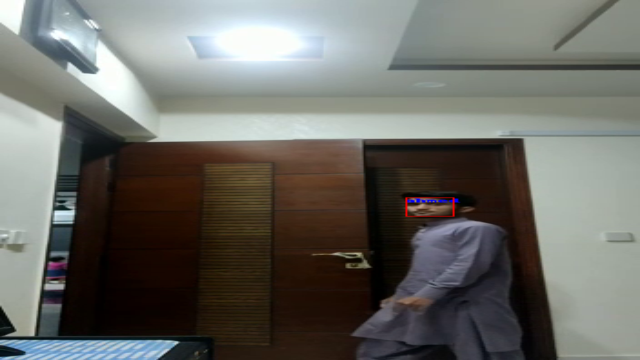

In [109]:
from IPython import display
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

In [112]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()

In [ ]:
## DON'T RUN THIS
pixels = extract_face('data/train/ahmed/IMG_20210828_100731.jpg')
len(pixels)

In [ ]:
## this for visualization only
i = 1
fig = plt.figure(figsize=(10, 7))
for pixel in pixels:
    fig.add_subplot(1,1,i)
    plt.imshow(pixel)
    plt.axis('off')
    i = i + 1

In [ ]:
## don't run this
img = cv2.imread("data/train/ahmed/IMG_20210828_100731.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape